# Detecção de Intrusões em Redes Usando Perceptron Multicamadas Sem o Src_bytes

### Pre-Process.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 4.2 Carregamento do dataset
train_df = pd.read_csv("Train_data.csv").drop(columns=["src_bytes"])
test_df  = pd.read_csv("Test_data.csv").drop(columns=["src_bytes"])

print("Shape treino:", train_df.shape)
print("Colunas treino:", train_df.columns)
print("Valor único da coluna alvo:\n", train_df["class"].value_counts(dropna=False))
print("\n===================\n")

print("Shape Teste:", test_df.shape)
print("Colunas teste:", test_df.columns)

Shape treino: (25192, 41)
Colunas treino: Index(['duration', 'protocol_type', 'service', 'flag', 'dst_bytes', 'land',
       'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'],
      dtype='object')
Valor único da coluna alvo:
 class
normal     13449
anomaly    11743
Name: count, dtype: int64


Shape Teste: (22544, 40)
Colun

In [3]:
X = train_df.drop(columns=["class"])
y = train_df["class"]

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.30,
    random_state=19,
    stratify=y
)

In [5]:
categorical_cols = X_train.select_dtypes(include=["object"]).columns

X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols)

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

### Treino e Teste

In [7]:
mlp = MLPClassifier(
    hidden_layer_sizes=(120, 80),
    solver='adam',
    max_iter=300,
    random_state=19
)

mlp.fit(X_train_scaled, y_train)

,hidden_layer_sizes,"(120, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,19


In [8]:
y_pred = mlp.predict(X_valid_scaled)


In [9]:
print("Distribuição das classes em y_valid:")
print(y_valid.value_counts())

print("\nDistribuição das classes previstas:")
print(pd.Series(y_pred).value_counts())

Distribuição das classes em y_valid:
class
normal     4035
anomaly    3523
Name: count, dtype: int64

Distribuição das classes previstas:
normal     4021
anomaly    3537
Name: count, dtype: int64


### Avaliação do Modelo

In [10]:
# Acurácia
accuracy = accuracy_score(y_valid, y_pred)
print(f"\nAcurácia: {accuracy:.10f}\n")

# Relatório detalhado por classe
print("Relatório de Classificação:")
print(classification_report(y_valid, y_pred, zero_division=0, digits=4))


Acurácia: 0.9952368351

Relatório de Classificação:
              precision    recall  f1-score   support

     anomaly     0.9929    0.9969    0.9949      3523
      normal     0.9973    0.9938    0.9955      4035

    accuracy                         0.9952      7558
   macro avg     0.9951    0.9953    0.9952      7558
weighted avg     0.9952    0.9952    0.9952      7558



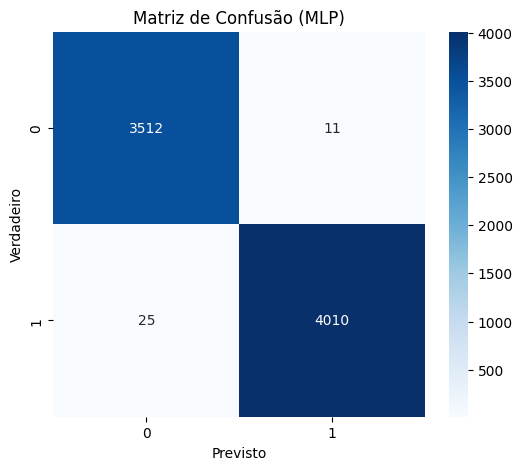

In [11]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão (MLP)")
plt.show()

In [ ]:


# Calcular importância via permutação (convertido para array para evitar warning)
resultado = permutation_importance(
    mlp,
    X_valid.values,   # evita o warning
    y_valid,
    n_repeats=10,
    random_state=123,
    n_jobs=-1
)

# Criar Series com nomes originais das features
importances = pd.Series(resultado.importances_mean, index=X_valid.columns)

# Ordenar e truncar para top 20 (ou outro valor)
importances = importances.sort_values(ascending=False)
top_k = 20
importances_trunc = importances.head(top_k)

print(f"Top {top_k} Features Mais Importantes:")
print(importances_trunc)

# Plot
plt.figure(figsize=(12,6))
importances_trunc.plot(kind='bar')
plt.title(f"Top {top_k} Importância das Features (Permutation Importance - MLP)")
plt.ylabel("Impacto na Acurácia")
plt.show()


### Prevendo e utilizando no conjunto de teste

anomaly    42.592264
normal     57.407736
Name: proportion, dtype: float64


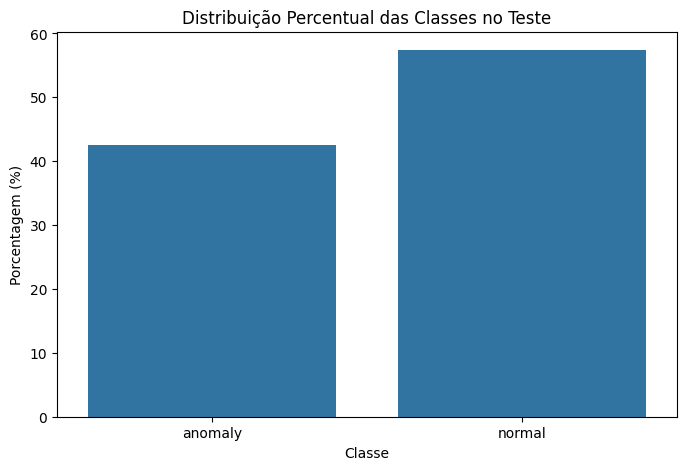

In [ ]:
X_test = test_df.copy()

categorical_cols = X_test.select_dtypes(include=["object"]).columns
X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = scaler.transform(X_test)

test_pred = mlp.predict(X_test_scaled)

percentuais = (pd.Series(test_pred).value_counts(normalize=True) * 100).sort_index()
print(percentuais)

plt.figure(figsize=(8,5))
sns.barplot(x=percentuais.index, y=percentuais.values)
plt.title("Distribuição Percentual das Classes no Teste")
plt.xlabel("Classe")
plt.ylabel("Porcentagem (%)")
plt.show()
